In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import random_split, DataLoader
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import optuna

In [3]:
torch.cuda.is_available(), torch.__version__

(True, '2.9.1+cu130')

In [4]:
if torch.cuda.is_available():
    current_device_idx = torch.cuda.current_device()
    device_properties = torch.cuda.get_device_properties(current_device_idx)
    print(f"Device Properties: {device_properties}")

Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 5060 Ti', major=12, minor=0, total_memory=15842MB, multi_processor_count=36, uuid=277ff69b-c475-efe9-d27e-ab49e8a0c81c, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=32MB)


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# tranformation from pixel to tensors
transform = transforms.ToTensor()

In [7]:
# Download train data from open datasets.
train_full_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# train and validation size
train_size = int(0.83 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size

train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

# Download test data from open datsets.
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [9]:
# convert to pytorch dataloader type
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


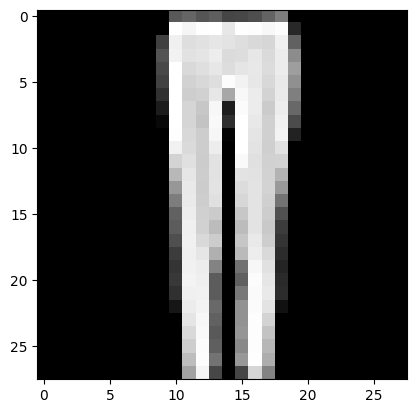

Label: Trouser


In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {labels_map[label.item()]}')

In [11]:
# Neural network model
class NNetwork_1(nn.Module):
    def __init__(self):
        super(NNetwork_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 264),
            nn.ReLU(),
            nn.Linear(264, 128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
model = NNetwork_1().to(device)

In [13]:
out = summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       401,920
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       135,432
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       33,920
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       10,836
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       850
Total params: 582,958
Trainable params: 582,958
Non-trainable params: 0


In [14]:
# writer for runs
writer = SummaryWriter(log_dir='runs/experiments_1')

In [15]:
# hyperparameters, loss and optimizer
lr = 1e-3
epochs = 50

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [16]:
train_losses = []
val_losses = []
val_accuracies = []


# training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    for batch, (x,y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # compute error
        prediction = model(x)
        loss = loss_fn(prediction, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(x)
            print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

In [17]:
# evaluating loop
def evaluate_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    # correct /= size
    val_acc = correct / size
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Val Error: \n Val Accuracy: {(100*val_acc):>0.1f}%, Avg. Loss: {val_loss:8f} \n")

In [18]:
for i in range(epochs):
    print(f"Epoch: {i+1}\n-----------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    evaluate_loop(val_dataloader, model, loss_fn)
    evaluate_loop(test_dataloader, model, loss_fn)

     # Log to TensorBoard
    writer.add_scalar("Loss/train", train_losses[-1], i)
    writer.add_scalar("Loss/val", val_losses[-1], i)
    writer.add_scalar("Accuracy/val", val_accuracies[-1], i)

Epoch: 1
-----------------------
Loss: 2.286225 [    0/49800]
Loss: 2.294676 [ 6400/49800]
Loss: 2.302040 [12800/49800]
Loss: 2.306388 [19200/49800]
Loss: 2.313525 [25600/49800]
Loss: 2.316284 [32000/49800]
Loss: 2.307558 [38400/49800]
Loss: 2.295982 [44800/49800]
Val Error: 
 Val Accuracy: 10.0%, Avg. Loss: 2.302588 

Val Error: 
 Val Accuracy: 10.0%, Avg. Loss: 2.302196 

Epoch: 2
-----------------------
Loss: 2.287417 [    0/49800]
Loss: 2.306694 [ 6400/49800]
Loss: 2.286623 [12800/49800]
Loss: 2.297097 [19200/49800]
Loss: 2.312845 [25600/49800]
Loss: 2.295421 [32000/49800]
Loss: 2.298646 [38400/49800]
Loss: 2.307910 [44800/49800]
Val Error: 
 Val Accuracy: 10.0%, Avg. Loss: 2.298463 

Val Error: 
 Val Accuracy: 10.0%, Avg. Loss: 2.298045 

Epoch: 3
-----------------------
Loss: 2.292217 [    0/49800]
Loss: 2.300758 [ 6400/49800]
Loss: 2.296957 [12800/49800]
Loss: 2.294186 [19200/49800]
Loss: 2.297361 [25600/49800]
Loss: 2.293203 [32000/49800]
Loss: 2.299236 [38400/49800]
Loss: 2.29

In [19]:
evaluate_loop(test_dataloader, model, loss_fn)

Val Error: 
 Val Accuracy: 77.2%, Avg. Loss: 0.621536 



In [20]:
# prediction
model.eval()

x, y = test_dataset[1][0], test_dataset[1][1]

# Add batch dimension and move only x to device
x = x.unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(x)
    pred_y = pred.argmax(1).item()  # highest logit = predicted class index
    predicted, actual = labels_map[pred_y], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"


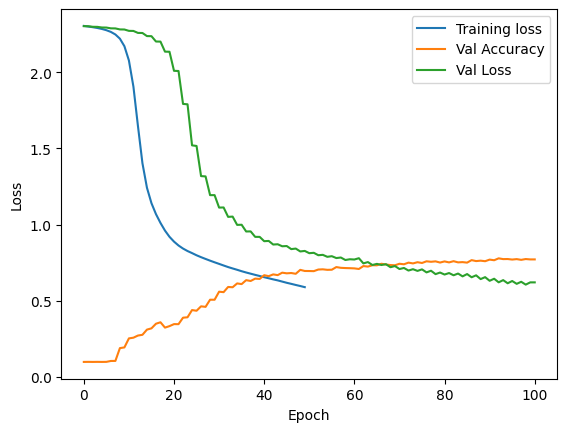

In [21]:
# visualising
fig = plt.Figure(figsize=(12,10))
plt.plot(train_losses, label='Training loss')
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
!tensorboard --logdir=./runs


/bin/bash: line 1: tensorboard: command not found


#### Hyperparameter tuning with Optuna

In [23]:
def objective(trial):
    # define parameters search sparse
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    hidden_size = trial.suggest_int("hidden_size", 64, 512, step=64)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = NNetwork_1().to(device)
    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    num_epochs = 5

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)

            # compute error
            prediction = model(x)
            loss = loss_fn(prediction, y)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_dataloader)
        trial.report(avg_train_loss, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # validation
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)
    val_acc = correct / total

    # --- Step 5: Return the metric you want to optimize ---
    return val_acc

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-11-13 19:32:41,561] A new study created in memory with name: no-name-d5e5461a-8b84-4f0d-a6d0-0badcf3b2d5f
/tmp/ipykernel_42813/78425232.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-11-13 19:32:48,446] Trial 0 finished with value: 0.4800980392156863 and parameters: {'lr': 0.002903712934740857, 'dropout': 0.40786076990389764, 'hidden_size': 192, 'batch_size': 128}. Best is trial 0 with value: 0.4800980392156863.
[I 2025-11-13 19:32:55,305] Trial 1 finished with value: 0.6626470588235294 and parameters: {'lr': 0.005620467995336631, 'dropout': 0.15649994671422426, 'hidden_size': 512, 'batch_size': 32}. Best is trial 1 with value: 0.6626470588235294.
[I 2025-11-13 19:33:02,252] Trial 2 finished with value: 0.7105882352941176 and parameters: {'lr': 0.0062342492288

Best trial:
  Accuracy: 0.7105882352941176
  Best params:
    lr: 0.006234249228853029
    dropout: 0.3820722943770998
    hidden_size: 320
    batch_size: 128


In [25]:
optuna.visualization.plot_optimization_history(study)
